In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def entropy(pmf, epsilon=1e-4):
    try:
        pmf = np.array(pmf)
        mask = pmf>epsilon
        pmf = pmf[mask]  # 0log0 = 0
        return -1.0 * np.dot(pmf, np.log2(pmf))
    except TypeError as te:
        print(pmf, "is not iterable")

# a = np.linspace(0, 1, 100)
# b = np.zeros(a.shape)
# for i, e in enumerate(a):
#     b[i] = entropy([e, 1-e])
# fig = plt.figure()
# plt.plot(a, b)
# plt.show()

def conditionalEntropy(cond_p, pmfs):
    assert len(cond_p) == len(pmfs)
    result = 0
    for i, p in enumerate(cond_p):
        result += p*entropy(pmfs[i, :])
    return result
    

def empiricalEntropy(label: pd.Series):
    pmf = label.value_counts().values / label.count()
    return entropy(pmf)

def empiricalConditionalEntropy(label: pd.Series, feature: pd.Series):
    assert label.count() == feature.count(), \
        "The length of label and feature should be the same when computing empirical conditional entropy"
    df = pd.DataFrame({'label':label, 'feature': feature})
    feature_values = feature.unique()  # get all distinct feature values
    result = 0
    for i, value in enumerate(feature_values):
        df_filtered = df.query('feature==@value')   # filter by feature value
        label_filtered = df_filtered['label']
        ee = empiricalEntropy(label_filtered)
        cond_p = feature.value_counts()[value]/feature.count()
        result += cond_p*ee
    return result

In [9]:
df = pd.read_csv('./test_data.csv', delimiter=',')
label = df['type']
empiricalEntropy(label)
empiricalConditionalEntropy(label=df['type'], feature=df['age'])
empiricalEntropy(label) - empiricalConditionalEntropy(label=df['type'], feature=df['work'])
empiricalEntropy(label) - empiricalConditionalEntropy(label=df['type'], feature=df['house'])
empiricalEntropy(label) - empiricalConditionalEntropy(label=df['type'], feature=df['credit'])

0.36298956253708536

In [10]:
class Node():
    def __init__(self, label=None, parent=None, children=None):
        self.parent = parent
        self.children = children
        self.label = label  
        self.leaf_label = None
        self.test_cond = None   # test condition of each internal node is here
                                # list of str (used in pd.DataFrame.query)
    
    def __str__(self, level=0):
        if not self.children:
            ret = "\t"*level + repr(self.leaf_label) + "\n"
        else:
            ret = "\t"*level + repr(self.label) + "\n"
        if self.children:
            for child in self.children:
                ret += child.__str__(level+1)
        return ret
    
    def mermaid(self):
        ss = self.gen_mermaid()
        ss = 'graph LR\nroot' + ss
        return ss
    
    def gen_mermaid(self, prefix='a'):
        if not self.children:
            ret = "--" + self.label + "-->" + prefix + "(" + repr(self.leaf_label) + ")\n"
        else:
            ret = "--" + self.label + "-->" + prefix + "(" + self.test_cond[0].split('==')[0] + ")\n" 
        if self.children:
            for j, child in enumerate(self.children):
                ret += prefix + "("+self.test_cond[0].split('==')[0]+")"
                ret += child.gen_mermaid(prefix+str(j))
        return ret
    
    
class DecisionTree():
    def __init__(self, train_data: pd.DataFrame, 
                    stop_threshold=1e-2):
        
        # pd.DataFrame.attrs should contain whether each column is discrete or not
        for c in train_data.columns.values:
            if c not in train_data.attrs.keys():
                raise ValueError("Input data (pd.DataFrame) should contain whether each column is discrete or not")
        
        self.stop_threshold = stop_threshold
        self.root = self.grow(train_data)
        self.root.label = 'root'

    def grow(self, data:pd.DataFrame):
        if self.stopping_condition(data):
            # finnally we reach the leaf
            leaf = Node()
            leaf.leaf_label = self.classify(data)
            return leaf
        else:
            root = Node(label=None, children=list())
            root.test_cond, attr = self.find_best_split(data)
            for lb in root.test_cond:
                assert type(lb) is str
                sub_data = data.query(lb)
                if sub_data.empty:
                    continue
                sub_data = sub_data.drop(columns=[attr])  # this attribute has been used this time
                child = self.grow(sub_data)
                child.parent = root
                child.label = lb
                root.children.append(child)
        return root

    def check_discrete(self, data: pd.DataFrame, col: str):
        return data.attrs[col]

    def stopping_condition(self, data:pd.DataFrame):
        assert len(data.columns.values) > 0, "Cannot find the label column"
        if len(data.columns.values) == 1:   # the last one column is the label of each sample
            # all attributes have been used, thus stop
            return True
        if data.iloc[:,-1].nunique() == 1:
            return True
        max_info_gain, _, _ = self.find_largest_info_gain(data)
        # print(max_info_gain)
        if max_info_gain < self.stop_threshold:
            return True
        
        return False

    def find_best_split(self, data:pd.DataFrame):
        # select the attribute with largest information gain
        _, attr_with_max_info_gain, attr_discrete = self.find_largest_info_gain(data)
        if attr_discrete:
            # for example, if available values for attr 'A' is [0, 1 ,2], then cond = ['A==0', 'A==1', 'A==2']
            cond = [attr_with_max_info_gain+'=='+str(i) for i in data[attr_with_max_info_gain].unique()]
        else:
            raise ValueError("Continuous data is not available now")
        return cond, attr_with_max_info_gain
    
    def find_largest_info_gain(self, data:pd.DataFrame):
        """ select the attribute with largest information gain

        Args:
            data (pd.DataFrame): data with label in the last column

        Returns:
            float: attr_with_max_info_gain, max_info_gain, attr_discrete
        """
        max_info_gain = -np.inf
        for col in data.columns.values[:-1]: # the last column is the label, thus ignore it
            discrete = self.check_discrete(data, col)
            if discrete:
                info_gain = empiricalEntropy(data.iloc[:, -1]) - \
                            empiricalConditionalEntropy(label=data.iloc[:, -1], feature=data[col])
            else:
                raise ValueError("Continuous data is not available now")
            # get largest info gain
            if info_gain > max_info_gain:
                max_info_gain = info_gain
                attr_with_max_info_gain = col
                attr_discrete = discrete
        return max_info_gain, attr_with_max_info_gain, attr_discrete
        
    def classify(self, data:pd.DataFrame):
        return str(data.iloc[:,-1].mode().values[0])

dataframe = pd.read_csv('./test_data.csv', delimiter=',')
dataframe.attrs =dict(zip(dataframe.columns.values, [True, True, True, True, True]))
tree = DecisionTree(dataframe)

print(tree.root.mermaid())

graph LR
root--root-->a(house)
a(house)--house==0-->a0(work)
a0(work)--work==0-->a00('0')
a0(work)--work==1-->a01('1')
a(house)--house==1-->a1('1')



In [6]:
tree.find_largest_info_gain(dataframe)

(0.9576351984400187, 'credit', True)

In [74]:
df = pd.read_csv('./test_data.csv', delimiter=',')
df.attrs =dict(zip(df.columns.values, [True, True, True, True, True]))
ss = df.drop(columns=['credit'])
ss = df.query('work==5')
ss.empty

True

   1. sepal length in cm
   2. sepal width in cm
   3. petal length in cm
   4. petal width in cm
   5. class: 

In [13]:
data_path = '.\data\iris.data'
iris_data = pd.read_csv(data_path, 
        names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'], 
        delimiter=',')
iris_data

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


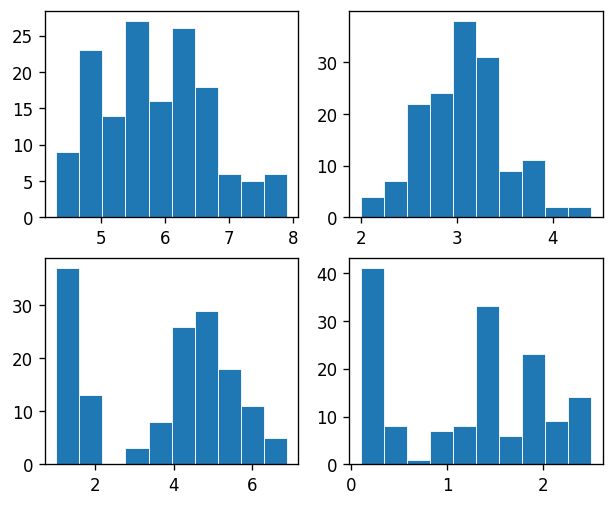

In [31]:
fig, axs = plt.subplots(2,2, figsize=(6, 5), dpi=120)
bins = [10,10,10,10]
for i in range(2):
    for j in range(2):
        ax = axs[i, j]
        ax.hist(iris_data.iloc[:, i*2+j].values, bins=bins[i*2+j], linewidth=0.5, edgecolor="white")
plt.show()


In [33]:
class Kmeans1d():
    def __init__(self):
        pass
    
    def fit(self, data: np.ndarray, k, epsilon=1e-2):
        assert len(data.shape) == 1, "The input data of Kmeans1d should be 1 dim"
        # initialization
        low_boundary = np.min(data)
        up_boundary = np.max(data)
        center_point = np.linspace(low_boundary, up_boundary, )
        



KMeans()

In [35]:
a = np.

(3,)